# **INSTALLATION**

In [ ]:
#!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#!pip install tensorflow-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 578.0 MB 19 kB/s 
     |████████████████████████████████| 1.7 MB 51.4 MB/s 
     |████████████████████████████████| 438 kB 73.2 MB/s 
     |████████████████████████████████| 5.9 MB 53.2 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5

# DRIVE MOUNTING

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports and Images

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import cv2

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Activation, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

from PIL import Image

from sklearn.metrics import confusion_matrix, classification_report
import itertools
import pandas as pd
import seaborn as sn

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import pprint

In [3]:
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='/content/drive/MyDrive/Colab Notebooks/NST/pretrained_model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg.trainable = False
pp.pprint(vgg)

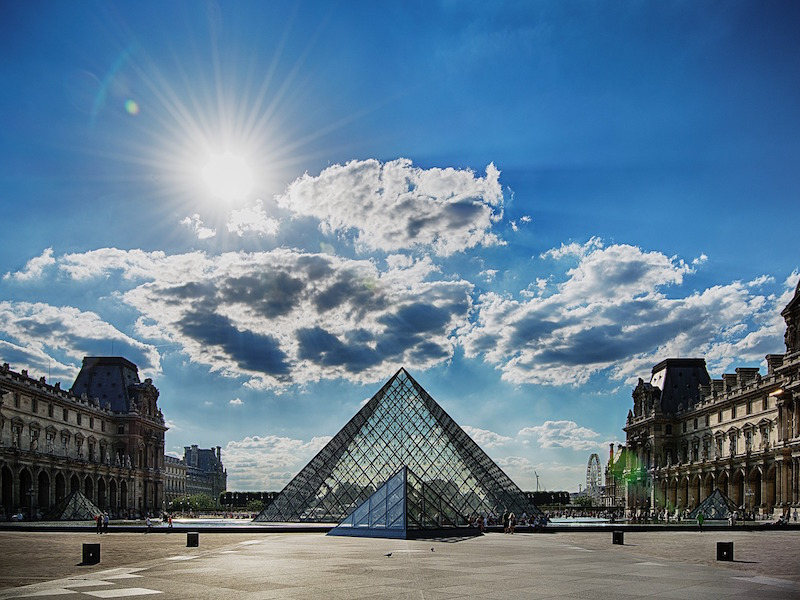

In [4]:
content_image = Image.open("/content/drive/MyDrive/Colab Notebooks/NST/images/louvre.jpg")
content_image

WORK-1

In [5]:
def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
   
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_C_unrolled = tf.reshape(a_C, shape=[m, n_H * n_W, n_C]) # Or tf.reshape(a_C, shape=[m, -1 , n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, n_H * n_W, n_C]) # Or tf.reshape(a_G, shape=[m, -1 , n_C])
    

    J_content =  tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled))/(4.0 * n_H * n_W * n_C)
    
    ### END CODE HERE
    
    return J_content

Work-2

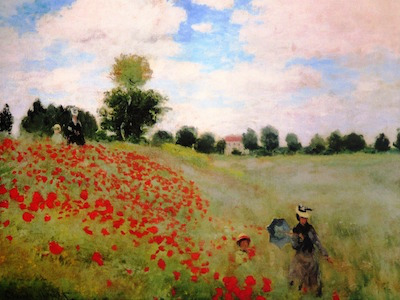

In [6]:
example = Image.open("/content/drive/MyDrive/Colab Notebooks/NST/images/monet.jpg")
example

In [7]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """  
    
    GA = tf.matmul(A, tf.transpose(A))


    return GA

In [8]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
   
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
   
    a_S = tf.transpose(tf.reshape(a_S, shape=[-1, n_C]))
    
    a_G = tf.transpose(tf.reshape(a_G, shape=[-1, n_C]))
    
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    
    J_style_layer = tf.reduce_sum(tf.square(GS - GG))/(4.0 *(( n_H * n_W * n_C)**2))
 
    
    return J_style_layer

## VGG

In [9]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 400, 400, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 400, 400, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 200, 200, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 200, 200, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 200, 200, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 100, 100, 128)     0     

In [10]:
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [11]:
vgg.get_layer('block5_conv4').output

<KerasTensor: shape=(None, 25, 25, 512) dtype=float32 (created by layer 'block5_conv4')>

In [12]:
STYLE_LAYERS = [
    ('block1_conv1', 1.0),
    ('block2_conv1', 0.8),
    ('block3_conv1', 0.7),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.1)]

Work-3

In [13]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    style_image_output -- our tensorflow model
    generated_image_output --
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
   
    J_style = 0

    
    a_S = style_image_output[1:]

    
    a_G = generated_image_output[1:]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
    
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        J_style += weight[1] * J_style_layer

    return J_style

In [14]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    J = alpha * J_content + beta * J_style

    return J


# **Loading Content Image**

(1, 400, 400, 3)


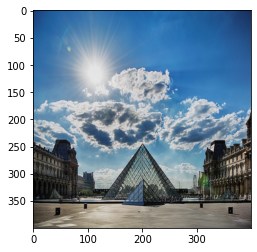

In [15]:
content_image = np.array(Image.open("/content/drive/MyDrive/Colab Notebooks/NST/images/louvre.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

(1, 400, 400, 3)


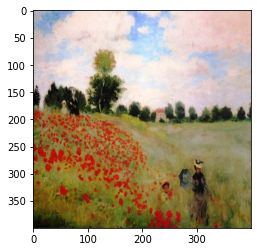

In [16]:
style_image =  np.array(Image.open("/content/drive/MyDrive/Colab Notebooks/NST/images/monet.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

(1, 400, 400, 3)


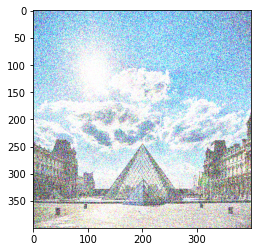

In [17]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), 0, 0.8)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

# LOADING **MODEL**

In [18]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [19]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [20]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style enconder

In [21]:
# Assign the content image to be the input of the VGG model.  
# Set a_C to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input.
a_G = vgg_model_outputs(generated_image)

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

print(J_content)

tf.Tensor(0.011655459, shape=(), dtype=float32)


In [22]:
# Assign the input of the model to be the "style" image 
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

# Compute the style cost
J_style = compute_style_cost(a_S, a_G)
print(J_style)

tf.Tensor(3371.7368, shape=(), dtype=float32)


In [23]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    
    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image
    
    Arguments:
    tensor -- Tensor
    
    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

# **Train**

In [24]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.03)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        
        a_G = vgg_model_outputs(generated_image)
        
        J_style = compute_style_cost(a_S, a_G)

        J_content = compute_content_cost(a_C, a_G)
        
        J = total_cost(J_content, J_style)
        
        
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    # For grading purposes
    return J

In [25]:
generated_image = tf.Variable(generated_image)

Epoch 0 


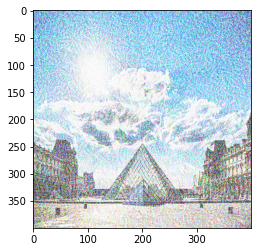

Epoch 250 


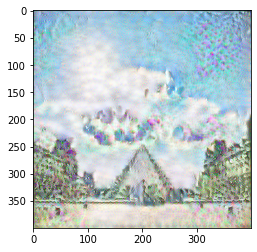

Epoch 500 


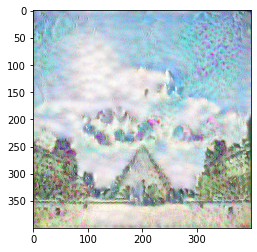

Epoch 750 


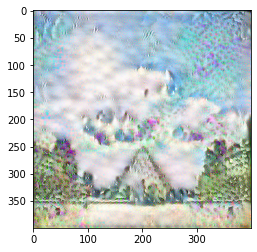

Epoch 1000 


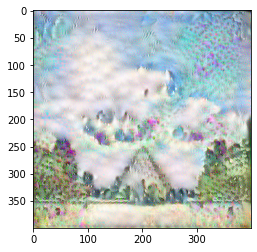

Epoch 1250 


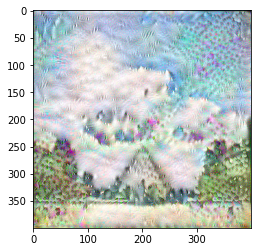

Epoch 1500 


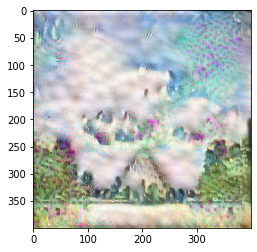

Epoch 1750 


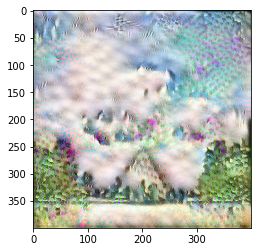

Epoch 2000 


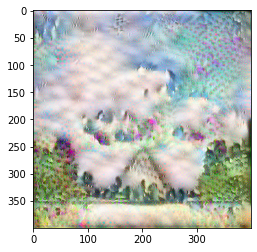

Epoch 2250 


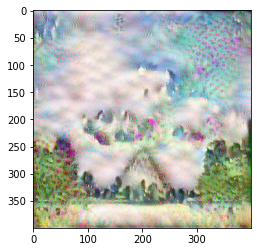

Epoch 2500 


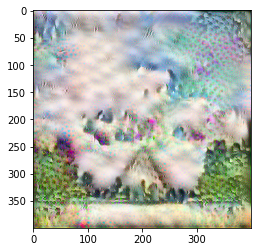

In [26]:
epochs = 2501
for i in range(epochs):
    train_step(generated_image)
    if i % 250 == 0:
        print(f"Epoch {i} ")
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"/content/drive/MyDrive/Colab Notebooks/NST/output/image_{i}.jpg")
        plt.show() 

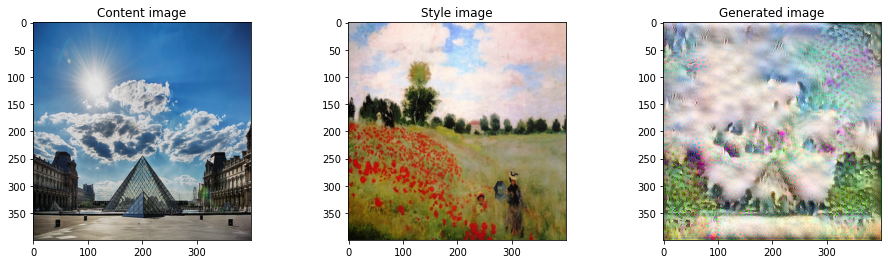

In [27]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()